<a href="https://colab.research.google.com/github/jinokwon/Predicting_Retweet_Rates/blob/master/Jino_Kwon_Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
#Activating Google Drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import plotly.graph_objs as go

In [ ]:
###Google Drive
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from numpy import inf

from nltk.tokenize import word_tokenize
from nltk.collocations import *
from nltk import FreqDist
lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Senator raw Tweeter data
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/thesis/senator_all.csv")
print(df[(df['retweet_count'] == 0)].count)
df.head()

<bound method DataFrame.count of        rowname     elite_new  ... shared_negCount shared_posCount
426      427.0  amyklobuchar  ...               0               0
1512    1513.0   BillCassidy  ...               0               0
1516    1517.0   BillCassidy  ...               0               0
1519    1520.0   BillCassidy  ...               0               0
1530    1531.0   BillCassidy  ...               0               0
...        ...           ...  ...             ...             ...
98513  91984.0    ThomTillis  ...               0               0
99530  93001.0      timkaine  ...               1               0
99574  93045.0      timkaine  ...               0               0
99625  93096.0      timkaine  ...               0               0
99636  93107.0      timkaine  ...               1               0

[7443 rows x 21 columns]>


,rowname,elite_new,created_at,text,retweet_count,favorite_count,url,media,followers,elite_idx,dwscore.y,dw_extr,dwextr_rs,genderfx,AffectCount,MoralCount,shared,neg_uniqueCount,pos_uniqueCount,shared_negCount,shared_posCount
0,1.0,alfranken,10/7/2016 23:56,I'll be sitting down w/ @billmaher on @RealTim...,268,1202,-0.5,-0.5,264601.0,1,-0.405,0.405,0.405,0.5,1,0,0,0,1,0,0
1,2.0,alfranken,10/5/2016 16:05,.@realDonaldTrump is tremendously indefensible...,110,268,0.5,-0.5,264601.0,1,-0.405,0.405,0.405,0.5,0,0,0,0,0,0,0
2,3.0,alfranken,10/5/2016 15:39,#FrankenFactcheck: @realDonaldTrump really did...,44,82,-0.5,0.5,264601.0,1,-0.405,0.405,0.405,0.5,0,0,0,0,0,0,0
3,4.0,alfranken,10/5/2016 15:37,Did @realdonaldtrump really say that more coun...,47,128,-0.5,0.5,264601.0,1,-0.405,0.405,0.405,0.5,1,1,0,1,0,0,0
4,5.0,alfranken,10/5/2016 15:37,#FrankenFactcheck: @realDonaldTrump really did...,29,62,0.5,-0.5,264601.0,1,-0.405,0.405,0.405,0.5,0,0,0,0,0,0,0


# Data Preparation

In [ ]:
# Drop unnecessary columns
df = df.drop(["rowname", "created_at", "favorite_count", "elite_idx", "dw_extr", "dwextr_rs", "AffectCount", "MoralCount", "neg_uniqueCount",	"pos_uniqueCount", "shared_negCount", "shared_posCount"], axis=1)
df.rename(columns={"elite_new": "senator", "dwscore.y": "dwscore", "genderfx":"gender", "shared":"moral-emo"}, inplace = True)

# Recode categorical values so that '1' means 'yes' and '0' means 'no'
df.url = df.url + 0.5
df.media = df.media + 0.5
df.gender = df.gender + 0.5

df.head()

,senator,text,retweet_count,url,media,followers,dwscore,gender,moral-emo
0,alfranken,I'll be sitting down w/ @billmaher on @RealTim...,268,0.0,0.0,264601.0,-0.405,1.0,0
1,alfranken,.@realDonaldTrump is tremendously indefensible...,110,1.0,0.0,264601.0,-0.405,1.0,0
2,alfranken,#FrankenFactcheck: @realDonaldTrump really did...,44,0.0,1.0,264601.0,-0.405,1.0,0
3,alfranken,Did @realdonaldtrump really say that more coun...,47,0.0,1.0,264601.0,-0.405,1.0,0
4,alfranken,#FrankenFactcheck: @realDonaldTrump really did...,29,1.0,0.0,264601.0,-0.405,1.0,0


In [ ]:
# Clean and Lemmatize
df1 = df.copy() 

stop_words = set(stopwords.words('english'))

punctuation = '''!"@#$%&'()*+,-./:;<=>?[\]^_`{|}~'''
def clean_lemma(instring, spaces = True): #removes punctuation and double spaces, replacing them w/ single spaces
    instring.replace("\n"," ")
    for x in punctuation:
            instring = instring.replace(x, " ")
    if spaces:
        while instring.find("  ") > -1:
            instring = instring.replace("  ", " ")
    else:
        while instring.find(" ") > -1:
            instring = instring.replace(" ","")
    instring = [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(instring)]
    instring = [word for word in instring if word not in stop_words]
    instring = ' '.join(instring)
    return instring

df1['clean_text'] = df1['text'].str.lower()
df1['clean_text'] = df1.clean_text.apply(clean_lemma)
df1.tail()

,senator,text,retweet_count,url,media,followers,dwscore,gender,moral-emo,clean_text
99745,timkaine,The @NRA opposes common sense solutions to gun...,61,0.0,0.0,344733.0008,-0.235,1.0,0,nra opposes common sense solution gun violence...
99746,timkaine,We need to create a records check system to ke...,3,0.0,0.0,344733.0008,-0.235,1.0,0,need create record check system keep weapon ha...
99747,timkaine,Epidemic of gun violence needs a comprehensive...,25,0.0,0.0,344733.0008,-0.235,1.0,0,epidemic gun violence need comprehensive solut...
99748,timkaine,Headed to a #stopgunviolence press conference ...,12,1.0,0.0,344733.0008,-0.235,1.0,1,headed stopgunviolence press conference unveil...
99749,timkaine,Headed to a Armed Service Committee hearing on...,9,1.0,0.0,344733.0008,-0.235,1.0,0,headed armed service committee hearing russian...


In [ ]:
# add a column for retweetablity
def retweetable(x):
    if x < 6 : return 0
    else : return 1
  
df1["retweetable"] = df1["retweet_count"].apply(retweetable)
print(df1["retweetable"].value_counts())
df1.head()

1    50234
0    49516
Name: retweetable, dtype: int64


,senator,text,retweet_count,url,media,followers,dwscore,gender,moral-emo,clean_text,retweetable
0,alfranken,I'll be sitting down w/ @billmaher on @RealTim...,268,0.0,0.0,264601.0,-0.405,1.0,0,sitting w billmaher realtimers tonight talk ta...,1
1,alfranken,.@realDonaldTrump is tremendously indefensible...,110,1.0,0.0,264601.0,-0.405,1.0,0,realdonaldtrump tremendously indefensible http...,1
2,alfranken,#FrankenFactcheck: @realDonaldTrump really did...,44,0.0,1.0,264601.0,-0.405,1.0,0,frankenfactcheck realdonaldtrump really toovil...,1
3,alfranken,Did @realdonaldtrump really say that more coun...,47,0.0,1.0,264601.0,-0.405,1.0,0,realdonaldtrump really say country nuclear wea...,1
4,alfranken,#FrankenFactcheck: @realDonaldTrump really did...,29,1.0,0.0,264601.0,-0.405,1.0,0,frankenfactcheck realdonaldtrump really http c...,1


## Sentiment Analysis

In [ ]:
# Prepping the NRC dictionary for sentiment analysis
filepath = "/content/drive/My Drive/Colab Notebooks/thesis/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t')
# I'm deleting a list of entries that are not associated with any emotion
nrc_df = nrc_df[nrc_df.association != 0]
nrc_df.head()

,word,emotion,association
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1


In [ ]:
# Create a 'outrage' dictionary
nrc_outrage = nrc_df[(nrc_df.emotion == 'anger') | (nrc_df.emotion == 'disgust')]
# Create a 'fear' dictionary
nrc_fear = nrc_df[nrc_df.emotion == 'fear']
# Create a 'positive' dictionary
nrc_pos = nrc_df[nrc_df.emotion == 'positive']
# Create a 'negative' dictionary
nrc_neg = nrc_df[nrc_df.emotion == 'negative']

In [ ]:
# Word counts for each dictionary
print(nrc_outrage.count)
print(nrc_fear.count)
print(nrc_pos.count)
print(nrc_neg.count)

<bound method DataFrame.count of                word  emotion  association
30        abandoned    anger            1
40      abandonment    anger            1
152      aberration  disgust            1
170           abhor    anger            1
172           abhor  disgust            1
...             ...      ...          ...
141222     wrongful  disgust            1
141230      wrongly    anger            1
141470         yell    anger            1
141500         yelp    anger            1
141640        youth    anger            1

[2305 rows x 3 columns]>
<bound method DataFrame.count of                word emotion  association
23          abandon    fear            1
33        abandoned    fear            1
43      abandonment    fear            1
133       abduction    fear            1
173           abhor    fear            1
...             ...     ...          ...
141233      wrongly    fear            1
141263   xenophobia    fear            1
141473         yell    fear        

In [ ]:
# Create a function for 'outrage' score
def outrage_senti(txt):
    token = nltk.word_tokenize(txt)
    outrage_count = 0
    for word in token:
        for o in nrc_outrage['word']:
            if word == o:
                outrage_count += 1
    return outrage_count / len(token)

# Create a function for 'fear' score
def fear_senti(txt):
    token = nltk.word_tokenize(txt)
    fear_count = 0
    for word in token:
        for o in nrc_fear['word']:
            if word == o:
                fear_count += 1
    return fear_count / len(token)

# Create a fuction for 'posneg' score
def posneg(txt):
    token = nltk.word_tokenize(txt)
    pos_count = 0
    neg_count = 0
    for word in token:
        for p in nrc_pos['word']:
            if word == p:
                pos_count += 1
        for n in nrc_neg['word']:
            if word == n:
                neg_count += 1
    return (pos_count - neg_count) / len(token)

In [ ]:
# Create a new column for 'outrage score'
df1['outrage'] = df1.clean_text.apply(outrage_senti)
# Create a new column for 'fear score'
df1['fear'] = df1.clean_text.apply(fear_senti)
# Create a new column for 'pos/neg' score
df1['posneg'] = df1.clean_text.apply(posneg)

In [ ]:
# The number of moral-emotional words needs to be divided by the length of tokens
df1 = df.copy() 
def token_count(txt):
    token = nltk.word_tokenize(txt)
    return len(token)
df1['token_num'] = df1.clean_text.apply(token_count)
df1['moral-emo'] = df1.apply(lambda x: x['moral-emo']/x['token_num'], axis=1)
# Dropping the 'token_num' column as it is no longer needed
df1 = df1.drop(["token_num"], axis=1)

In [ ]:
# Save the df1 file
df1.to_csv('preprocessed_data.csv')
!cp preprocessed_data.csv "/content/drive/My Drive/Colab Notebooks/thesis/"

In [ ]:
#  For explatory analysis

# Create a new column for a ln value of 'followers'
df1['ln_followers'] = np.log(df1['followers'])
# Create a new column for a ln value of 'retweet'
df1['ln_retweet'] = np.log(df1['retweet_count'])
# Replaced all '-inf' to 0
df1 = df1.replace({'ln_retweet': {-inf: 0}})

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log



In [ ]:
# Save the df1 file
df1.to_csv('preprocessed_data1.csv')
!cp preprocessed_data1.csv "/content/drive/My Drive/Colab Notebooks/thesis/"

# Building Prediction Models

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
from xgboost import plot_importance

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

# Supress Warningsv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/thesis/preprocessed_data.csv")
df.tail()

,Unnamed: 0,Unnamed: 0.1,senator,text,retweet_count,url,media,followers,dwscore,gender,moral-emo,clean_text,retweetable,outrage,fear,posneg
99745,99745,99745,timkaine,The @NRA opposes common sense solutions to gun...,61,0.0,0.0,344733.0008,-0.235,1.0,0.000000,nra opposes common sense solution gun violence...,1,0.200000,0.200000,-0.066667
99746,99746,99746,timkaine,We need to create a records check system to ke...,3,0.0,0.0,344733.0008,-0.235,1.0,0.000000,need create record check system keep weapon ha...,0,0.000000,0.000000,0.090909
99747,99747,99747,timkaine,Epidemic of gun violence needs a comprehensive...,25,0.0,0.0,344733.0008,-0.235,1.0,0.000000,epidemic gun violence need comprehensive solut...,1,0.285714,0.214286,0.000000
99748,99748,99748,timkaine,Headed to a #stopgunviolence press conference ...,12,1.0,0.0,344733.0008,-0.235,1.0,0.066667,headed stopgunviolence press conference unveil...,1,0.066667,0.133333,0.000000
99749,99749,99749,timkaine,Headed to a Armed Service Committee hearing on...,9,1.0,0.0,344733.0008,-0.235,1.0,0.000000,headed armed service committee hearing russian...,1,0.062500,0.312500,-0.062500


## Description of Data

### Heatmap (Correlation Matrix Visualization)

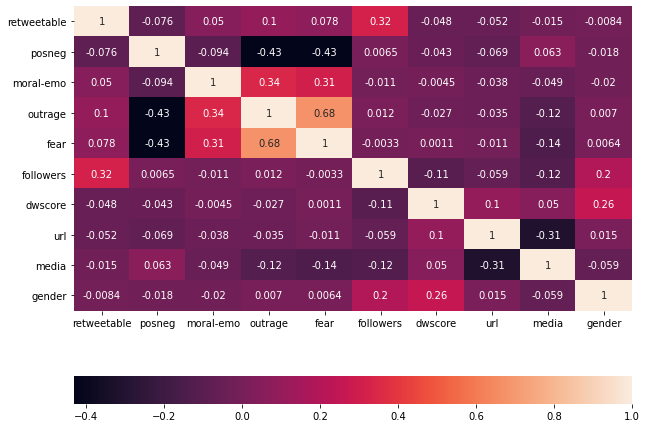

In [ ]:
features = df[['retweetable', 'posneg', 'moral-emo', 'outrage', 'fear', 'followers', 'dwscore', 'url', 'media', 'gender']]

plt.figure(figsize=(10,8))
sns.heatmap(features.corr(method='pearson'), annot=True, fmt='.2g', cbar_kws= {'orientation': 'horizontal'})

plt.show()

* how many rows had a zero for each sentiment analysis

In [ ]:
print("POSITIVE-NEGATIVE SENTIMENT")
print(df[(df['posneg'] == 0)].count)
print("MORAL-EMOTIONAL SENTIMENT")
print(df[(df['moral-emo'] == 0)].count)
print("OUTRAGE AND FEAR SENTIMENT")
print(df[(df['outrage'] == 0) & (df['fear'] == 0)].count)

POSITIVE-NEGATIVE SENTIMENT
<bound method DataFrame.count of        Unnamed: 0  Unnamed: 0.1    senator  ...   outrage      fear  posneg
1               1             1  alfranken  ...  0.000000  0.166667     0.0
2               2             2  alfranken  ...  0.000000  0.000000     0.0
3               3             3  alfranken  ...  0.000000  0.000000     0.0
4               4             4  alfranken  ...  0.000000  0.000000     0.0
6               6             6  alfranken  ...  0.000000  0.000000     0.0
...           ...           ...        ...  ...       ...       ...     ...
99741       99741         99741   timkaine  ...  0.000000  0.000000     0.0
99743       99743         99743   timkaine  ...  0.000000  0.000000     0.0
99744       99744         99744   timkaine  ...  0.222222  0.166667     0.0
99747       99747         99747   timkaine  ...  0.285714  0.214286     0.0
99748       99748         99748   timkaine  ...  0.066667  0.133333     0.0

[28557 rows x 16 columns]>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a578efeb8>]],
      dtype=object)

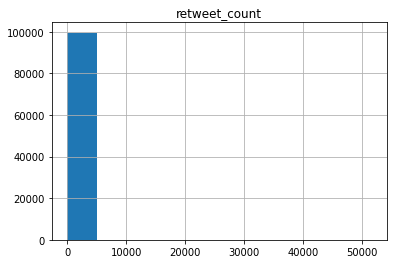

In [ ]:
df.hist(column='retweet_count')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb200d9588>]],
      dtype=object)

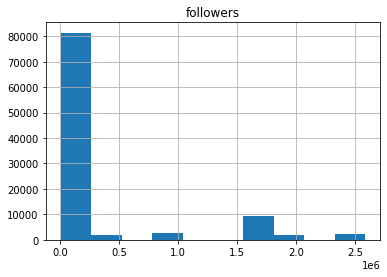

In [ ]:
df.hist(column='followers')

In [ ]:
df1 = df[['retweet_count', 'retweetable', 'posneg', 'moral-emo', 'fear', 'outrage', 'dwscore', 'url','media', 'gender', 'followers']].copy()
des = df1.describe()
des = des.transpose()
des

,count,mean,std,min,25%,50%,75%,max
retweet_count,99750.0,103.775639,577.659591,0.000,2.000,6.000000,17.000000,51554.000
retweetable,99750.0,0.503599,0.499990,0.000,0.000,1.000000,1.000000,1.000
posneg,99750.0,0.053447,0.120166,-1.000,0.000,0.058824,0.125000,1.000
moral-emo,99750.0,0.018793,0.040833,0.000,0.000,0.000000,0.000000,1.000
fear,99750.0,0.035475,0.059976,0.000,0.000,0.000000,0.066667,1.000
outrage,99750.0,0.039429,0.075141,0.000,0.000,0.000000,0.062500,1.000
dwscore,99750.0,0.084520,0.452687,-0.744,-0.341,0.258000,0.452000,0.919
url,99750.0,0.443328,0.496780,0.000,0.000,0.000000,1.000000,1.000
media,99750.0,0.220190,0.414377,0.000,0.000,0.000000,0.000000,1.000
gender,99750.0,0.787699,0.408939,0.000,1.000,1.000000,1.000000,1.000


## ML models with pos/neg

In [ ]:
# train test split
X = df[['url', 'media', 'followers', 'dwscore', 'gender', 'posneg']]
y = df['retweetable']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

* Penalizaed Logistic Regression Model w/ L2 Penalty

In [ ]:
logreg_pipe1 = make_pipeline(LogisticRegression(penalty='l2'))
logreg_param_grid1 = {'logisticregression__C': np.linspace(1, 100, 100)}
logreg_grid1 = GridSearchCV(logreg_pipe1, logreg_param_grid1, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("LOGISTIC REGRESSION W/ L2 Penalty (SCALED DATA)")
print("Best Parameter: {}".format(logreg_grid1.best_params_))
print("Test set Score: {:.4f}".format(logreg_grid1.score(X_test_scaled, y_test)))

y_pred = np.array(logreg_grid1.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

LOGISTIC REGRESSION W/ L2 Penalty (SCALED DATA)
Best Parameter: {'logisticregression__C': 3.0}
Test set Score: 0.6996
              precision    recall  f1-score   support

           0       0.61      0.85      0.71     12387
           1       0.75      0.45      0.57     12551

    accuracy                           0.65     24938
   macro avg       0.68      0.65      0.64     24938
weighted avg       0.68      0.65      0.64     24938



* KNN Classifier

In [ ]:
knn_pipe1 = make_pipeline(KNeighborsClassifier())
knn_param_grid1 = {'kneighborsclassifier__n_neighbors': range(1, 30)}
knn_grid1 = GridSearchCV(knn_pipe1, knn_param_grid1, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("KNN CLASSIFER (SCALED DATA)")
print("Best Parameter: {}".format(knn_grid1.best_params_))
print("Test set Score: {:.4f}".format(knn_grid1.score(X_test_scaled, y_test)))

y_pred = np.array(knn_grid1.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

KNN CLASSIFER (SCALED DATA)
Best Parameter: {'kneighborsclassifier__n_neighbors': 29}
Test set Score: 0.8113
              precision    recall  f1-score   support

           0       0.71      0.79      0.74     12387
           1       0.76      0.68      0.72     12551

    accuracy                           0.73     24938
   macro avg       0.73      0.73      0.73     24938
weighted avg       0.73      0.73      0.73     24938



* Random Forest Classifier

In [ ]:
rfc_pipe1 = make_pipeline(RandomForestClassifier(random_state=42))
rfc_param_grid1 = {'randomforestclassifier__n_estimators': [100, 500, 1000],
                  'randomforestclassifier__max_depth': [6, 7, 8]}
rfc_grid1 = GridSearchCV(rfc_pipe1, rfc_param_grid1, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("RANDOM FOREST CLASSIFIER")
print("Best Parameter: {}".format(rfc_grid1.best_params_))
print("Test set Score: {:.4f}".format(rfc_grid1.score(X_test_scaled, y_test)))

y_pred = np.array(rfc_grid1.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

RANDOM FOREST CLASSIFIER
Best Parameter: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 1000}
Test set Score: 0.8310
              precision    recall  f1-score   support

           0       0.73      0.80      0.76     12387
           1       0.78      0.71      0.74     12551

    accuracy                           0.75     24938
   macro avg       0.75      0.75      0.75     24938
weighted avg       0.75      0.75      0.75     24938



* XGBoost Model

In [ ]:
xgb_pipe1 = make_pipeline(xgb.XGBClassifier())
xgb_param_grid1 = {'xgbclassifier__max_depth': [6, 7, 8]}
xgb_grid1 = GridSearchCV(xgb_pipe1, xgb_param_grid1, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("XGBOOST CLASSIFIER")
print("Best Parameter: {}".format(xgb_grid1.best_params_))
print("Test set Score: {:.4f}".format(xgb_grid1.score(X_test_scaled, y_test)))

y_pred = np.array(xgb_grid1.predict(X_test_scaled))
print(classification_report(y_test, y_pred))


XGBOOST CLASSIFIER
Best Parameter: {'xgbclassifier__max_depth': 7}
Test set Score: 0.8376
              precision    recall  f1-score   support

           0       0.73      0.80      0.77     12387
           1       0.79      0.71      0.75     12551

    accuracy                           0.76     24938
   macro avg       0.76      0.76      0.76     24938
weighted avg       0.76      0.76      0.76     24938



### Create a Feature Importance Plot for the Best Model : XGBoost



In [ ]:
def plot_feature_importance(importance, names):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  print(fi_df)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  ax = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="Blues_r")

  for p in ax.patches:
    ax.annotate("%.4f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
  #Add chart labels
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

[0.07134619 0.06623826 0.24270885 0.18668644 0.01581809 0.41720217]
  feature_names  feature_importance
5        posneg            0.417202
2     followers            0.242709
3       dwscore            0.186686
0           url            0.071346
1         media            0.066238
4        gender            0.015818


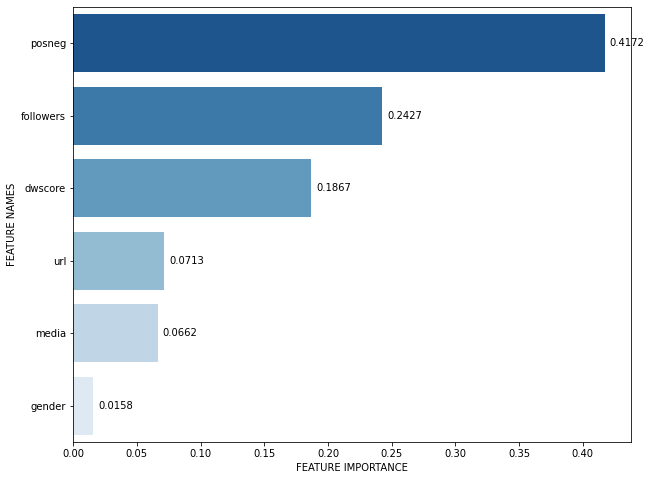

In [ ]:
# A feature importance plot for a XG Boost model
# fitting the model with best parameters
xgb1 = xgb.XGBClassifier(max_depth=7, importance_type='weight')
xgb1.fit(X_train_scaled, y_train)
print(xgb1.feature_importances_)
plot_feature_importance(xgb1.feature_importances_, X.columns)

## ML models with moral-emotions

In [ ]:
# train test split
X = df[['url', 'media', 'followers', 'dwscore', 'gender', 'moral-emo']]
y = df['retweetable']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

* Penalizaed Logistic Regression Model w/ L2 penalty

In [ ]:
logreg_pipe2 = make_pipeline(LogisticRegression(penalty='l2'))
logreg_param_grid2 = {'logisticregression__C': np.linspace(1, 100, 100)}
logreg_grid2 = GridSearchCV(logreg_pipe2, logreg_param_grid2, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("LOGISTIC REGRESSION W/ L2 Penalty (SCALED DATA)")
print("Best Parameter: {}".format(logreg_grid2.best_params_))
print("Test set Score: {:.4f}".format(logreg_grid2.score(X_test_scaled, y_test)))

y_pred = np.array(logreg_grid2.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

LOGISTIC REGRESSION W/ L2 Penalty (SCALED DATA)
Best Parameter: {'logisticregression__C': 17.0}
Test set Score: 0.7071
              precision    recall  f1-score   support

           0       0.61      0.85      0.71     12387
           1       0.76      0.46      0.57     12551

    accuracy                           0.65     24938
   macro avg       0.68      0.65      0.64     24938
weighted avg       0.68      0.65      0.64     24938



* KNN Classifier

In [ ]:
knn_pipe2 = make_pipeline(KNeighborsClassifier())
knn_param_grid2 = {'kneighborsclassifier__n_neighbors': range(1, 30)}
knn_grid2 = GridSearchCV(knn_pipe2, knn_param_grid2, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("KNN CLASSIFER (SCALED DATA)")
print("Best Parameter: {}".format(knn_grid2.best_params_))
print("Test set Score: {:.4f}".format(knn_grid2.score(X_test_scaled, y_test)))

y_pred = np.array(knn_grid2.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

KNN CLASSIFER (SCALED DATA)
Best Parameter: {'kneighborsclassifier__n_neighbors': 29}
Test set Score: 0.8183
              precision    recall  f1-score   support

           0       0.72      0.77      0.74     12387
           1       0.76      0.70      0.73     12551

    accuracy                           0.74     24938
   macro avg       0.74      0.74      0.74     24938
weighted avg       0.74      0.74      0.74     24938



* Random Forest Classifier

In [ ]:
rfc_pipe2 = make_pipeline(RandomForestClassifier(random_state=42))
rfc_param_grid2 = {'randomforestclassifier__n_estimators': [100, 500, 1000],
                  'randomforestclassifier__max_depth': [6, 7, 8]}
rfc_grid2 = GridSearchCV(rfc_pipe2, rfc_param_grid2, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("RANDOM FOREST CLASSIFIER")
print("Best Parameter: {}".format(rfc_grid2.best_params_))
print("Test set Score: {:.4f}".format(rfc_grid2.score(X_test_scaled, y_test)))

y_pred = np.array(rfc_grid2.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

RANDOM FOREST CLASSIFIER
Best Parameter: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 1000}
Test set Score: 0.8285
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     12387
           1       0.77      0.71      0.74     12551

    accuracy                           0.75     24938
   macro avg       0.75      0.75      0.75     24938
weighted avg       0.75      0.75      0.75     24938



* XGBoost Model

In [ ]:
xgb_pipe2 = make_pipeline(xgb.XGBClassifier())
xgb_param_grid2 = {'xgbclassifier__max_depth': [6, 7, 8]}
xgb_grid2 = GridSearchCV(xgb_pipe2, xgb_param_grid2, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("XGBOOST CLASSIFIER")
print("Best Parameter: {}".format(xgb_grid2.best_params_))
print("Test set Score: {:.4f}".format(xgb_grid2.score(X_test_scaled, y_test)))

y_pred = np.array(xgb_grid2.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

XGBOOST CLASSIFIER
Best Parameter: {'xgbclassifier__max_depth': 7}
Test set Score: 0.8343
              precision    recall  f1-score   support

           0       0.73      0.81      0.77     12387
           1       0.79      0.70      0.74     12551

    accuracy                           0.75     24938
   macro avg       0.76      0.75      0.75     24938
weighted avg       0.76      0.75      0.75     24938



### Create a Feature Importance Plot for the Best Model : XGBoost

  feature_names  feature_importance
5     moral-emo            0.310572
2     followers            0.277840
3       dwscore            0.196576
0           url            0.102709
1         media            0.097818
4        gender            0.014485


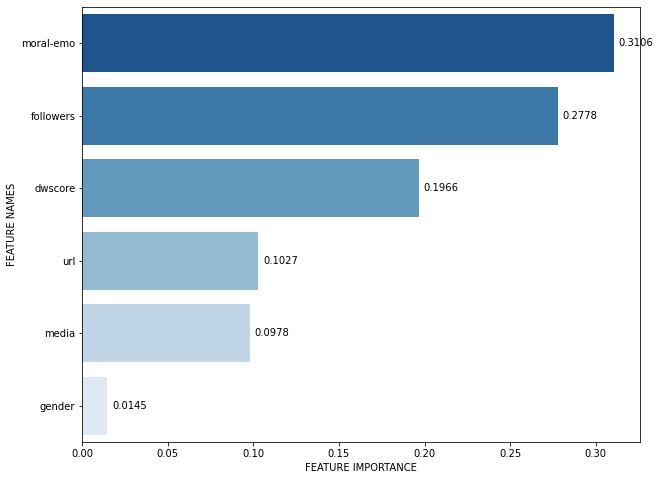

In [ ]:
# A feature importance plot for a XG Boost model
# fitting the model with best parameters
xgb2 = xgb.XGBClassifier(max_depth=7, importance_type='weight')
xgb2.fit(X_train_scaled, y_train)

plot_feature_importance(xgb2.feature_importances_, X.columns)

## ML models with outrage and fear

In [ ]:
# train test split
X = df[['url', 'media', 'followers', 'dwscore', 'gender', 'outrage', 'fear']]
y = df['retweetable']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

* Penalizaed Logistic Regression Model w/ L2 penalty

In [ ]:
logreg_pipe3 = make_pipeline(LogisticRegression(penalty='l2'))
logreg_param_grid3 = {'logisticregression__C': np.linspace(1, 100, 100)}
logreg_grid3 = GridSearchCV(logreg_pipe3, logreg_param_grid3, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("LOGISTIC REGRESSION W/ L2 Penalty (SCALED DATA)")
print("Best Parameter: {}".format(logreg_grid3.best_params_))
print("Test set Score: {:.4f}".format(logreg_grid3.score(X_test_scaled, y_test)))

y_pred = np.array(logreg_grid3.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

LOGISTIC REGRESSION W/ L2 Penalty (SCALED DATA)
Best Parameter: {'logisticregression__C': 5.0}
Test set Score: 0.7082
              precision    recall  f1-score   support

           0       0.61      0.84      0.71     12387
           1       0.75      0.46      0.57     12551

    accuracy                           0.65     24938
   macro avg       0.68      0.65      0.64     24938
weighted avg       0.68      0.65      0.64     24938



* KNN Classifier

In [ ]:
knn_pipe3 = make_pipeline(KNeighborsClassifier())
knn_param_grid3 = {'kneighborsclassifier__n_neighbors': range(1, 30)}
knn_grid3 = GridSearchCV(knn_pipe3, knn_param_grid3, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("KNN CLASSIFER (SCALED DATA)")
print("Best Parameter: {}".format(knn_grid3.best_params_))
print("Test set Score: {:.4f}".format(knn_grid3.score(X_test_scaled, y_test)))

y_pred = np.array(knn_grid3.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

KNN CLASSIFER (SCALED DATA)
Best Parameter: {'kneighborsclassifier__n_neighbors': 29}
Test set Score: 0.8092
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     12387
           1       0.77      0.68      0.72     12551

    accuracy                           0.73     24938
   macro avg       0.74      0.73      0.73     24938
weighted avg       0.74      0.73      0.73     24938



* Random Forest Classifier

In [ ]:
rfc_pipe3 = make_pipeline(RandomForestClassifier(random_state=42))
rfc_param_grid3 = {'randomforestclassifier__n_estimators': [100, 500, 1000],
                  'randomforestclassifier__max_depth': [6, 7, 8]}
rfc_grid3 = GridSearchCV(rfc_pipe3, rfc_param_grid3, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("RANDOM FOREST CLASSIFIER")
print("Best Parameter: {}".format(rfc_grid3.best_params_))
print("Test set Score: {:.4f}".format(rfc_grid3.score(X_test_scaled, y_test)))

y_pred = np.array(rfc_grid3.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

RANDOM FOREST CLASSIFIER
Best Parameter: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 1000}
Test set Score: 0.8310
              precision    recall  f1-score   support

           0       0.72      0.83      0.77     12387
           1       0.80      0.68      0.74     12551

    accuracy                           0.75     24938
   macro avg       0.76      0.75      0.75     24938
weighted avg       0.76      0.75      0.75     24938



* XGBoost Model

In [ ]:
xgb_pipe3 = make_pipeline(xgb.XGBClassifier())
xgb_param_grid3 = {'xgbclassifier__max_depth': [6, 7, 8]}
xgb_grid3 = GridSearchCV(xgb_pipe3, xgb_param_grid3, cv=kfold, scoring='roc_auc').fit(X_train_scaled, y_train)

print("XGBOOST CLASSIFIER")
print("Best Parameter: {}".format(xgb_grid3.best_params_))
print("Test set Score: {:.4f}".format(xgb_grid3.score(X_test_scaled, y_test)))

y_pred = np.array(xgb_grid3.predict(X_test_scaled))
print(classification_report(y_test, y_pred))

XGBOOST CLASSIFIER
Best Parameter: {'xgbclassifier__max_depth': 7}
Test set Score: 0.8393
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     12387
           1       0.80      0.70      0.74     12551

    accuracy                           0.76     24938
   macro avg       0.76      0.76      0.76     24938
weighted avg       0.76      0.76      0.76     24938



### Create a Feature Importance Plot for the Best Model

  feature_names  feature_importance
6          fear            0.234050
2     followers            0.230979
5       outrage            0.214603
3       dwscore            0.164278
0           url            0.076766
1         media            0.062436
4        gender            0.016888


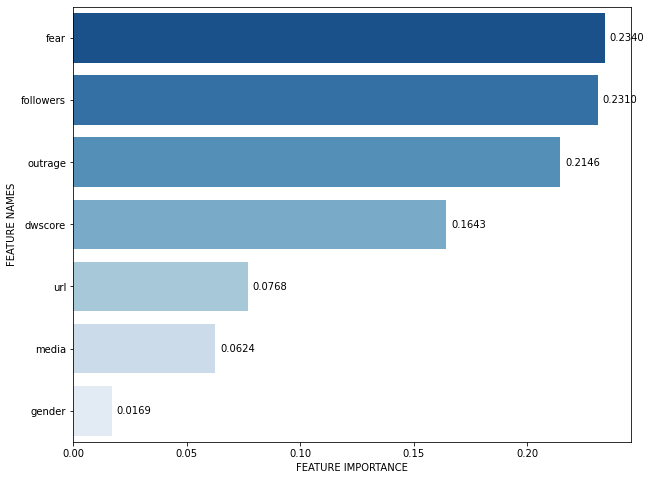

In [ ]:
# A feature importance plot for a XG Boost model
# fitting the model with best parameters
xgb3 = xgb.XGBClassifier(max_depth=7, importance_type='weight')
xgb3.fit(X_train_scaled, y_train)

plot_feature_importance(xgb3.feature_importances_, X.columns)

# Visualization
## General Performance

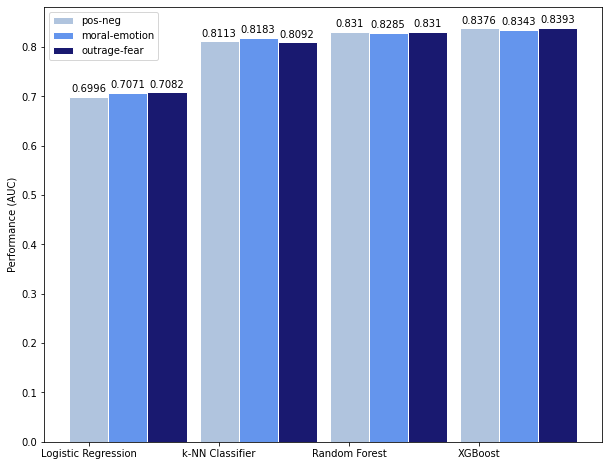

In [ ]:
# peformance results
pos_neg = [0.6996, 0.8113, 0.8310, 0.8376]
moral_emotion = [0.7071, 0.8183, 0.8285, 0.8343]
outrage_fear = [0.7082, 0.8092, 0.8310, 0.8393]

labels = ['Logistic Regression', 'k-NN Classifier', 'Random Forest', 'XGBoost']
bar_width = 0.3 # set the bar width

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10,8))
r1 = np.arange(len(pos_neg))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# make the plot
row1 = ax.bar(r1, pos_neg, color='lightsteelblue', width=bar_width, edgecolor='white', label='pos-neg')
row2 = ax.bar(r2, moral_emotion, color='cornflowerblue', width=bar_width, edgecolor='white', label='moral-emotion')
row3 = ax.bar(r3, outrage_fear, color='midnightblue', width=bar_width, edgecolor='white', label='outrage-fear')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance (AUC)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rows):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for r in rows:
        height = r.get_height()
        ax.annotate('{}'.format(height),
                    xy=(r.get_x() + r.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(row1)
autolabel(row2)
autolabel(row3)

plt.show()